# ResNet

## Dataset

In [94]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
train_image_zero, train_target_zero = trainset[0]

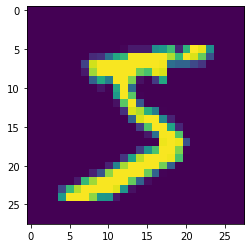

In [95]:
import matplotlib.pyplot as plt
plt.imshow(train_image_zero.permute(1, 2, 0))

In [96]:
train_target_zero

5

### Model

In [97]:
# for conv
# per_dim_conv_outs := (image_dim - kernel_size) + 1

# for max pool
# per_dim_conv_outs := image_dim // kernel_size

In [500]:
import torch
import torch.nn as nn
import einops
import torch.nn.functional as F

class BaseNN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, out_dim)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

class CNN(nn.Module):
    def __init__(self, out_dim=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=8,
            kernel_size=(7, 7),
            stride=2)
        self.maxpool = nn.MaxPool2d(
            kernel_size=(2, 2),
            stride=2)
        self.fc = nn.Linear(1600//8, out_dim)
    def forward(self, x, debug=False):
        if debug: print("x.shape", x.shape)
        x = self.conv1(x)
        if debug:  print("self.conv1(x).shape", x.shape)
        x = self.maxpool(x)
        if debug:  print("self.maxpool(x)", x.shape)
        x = torch.flatten(x, start_dim=1)
        if debug:  print("torch.flatten(x)", x.shape)
        x = F.log_softmax(self.fc(x), dim=1)
        return x
    def get_params(self):
        o = [param.numel() for param in self.parameters()]
        o = sum(o)
        return o

In [508]:
import torch
import torch.nn as nn
import einops
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, inp_kernel_size=64, out_kernel_size=64, stride=1, debug=False):
        super(Block, self).__init__()
        self.conv_layer = (not inp_kernel_size == out_kernel_size) or stride == 2
        self.conv1 = nn.Conv2d(
            in_channels=inp_kernel_size,
            out_channels=out_kernel_size,
            kernel_size=(3, 3),
            stride=stride,
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(out_kernel_size)
        self.conv2 = nn.Conv2d(
            in_channels=out_kernel_size,
            out_channels=out_kernel_size,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_kernel_size)

        if self.conv_layer:
            self.conv = nn.Conv2d(
                in_channels=inp_kernel_size,
                out_channels=out_kernel_size,
                kernel_size=(1, 1),
                stride=stride,
                padding=0,
                bias=False)
            self.bn = nn.BatchNorm2d(out_kernel_size)

        self.debug = debug

    def forward(self, x, debug=False):
        debug = debug or self.debug

        B, D, K_W, K_H = x.shape # (batch, feature_dim, kernel_w, kernel_h)
        if debug: print("Block Initial X Size:", (B, D, K_W, K_H))

        # conv 1
        r = self.conv1(x)
        if debug:  print(">> r = self.conv1(x)", r.shape)
        r = self.bn1(r)
        if debug:  print(">> r = self.bn1(r)", r.shape)
        r = F.relu(r, inplace=True)

        # conv 2
        r = self.conv2(r)
        if debug:  print(">> r = self.conv2(x)", r.shape)
        r = self.bn2(r)
        if debug:  print(">> r = self.bn2(r)", r.shape)
        # r = F.relu(r, inplace=True)

        # (possibly downsample) identity + residual
        if self.conv_layer:
            x = self.conv(x)
            if debug:  print(">> r = self.conv(x)", r.shape)
            x = self.bn(x)
            if debug:  print(">> r = self.bn(r)", r.shape)
            
        if debug:  print(">> x", x.shape)
        x = x + r
        if debug:  print(">> x = x + r", r.shape)

        # relu
        x = F.relu(x)
        if debug:  print(">> x = F.relu(x)", x.shape)

        # out
        return x

class Layer(nn.Module):
    def __init__(self, kernel_size, n_blocks=2, conv_block=False, debug=False):
        super(Layer, self).__init__()
        blocks  = []
        if conv_block:
            n_blocks -= 1
            blocks.append(
                Block(
                    inp_kernel_size=kernel_size // 2,
                    out_kernel_size=kernel_size,
                    stride=2,
                    debug=debug))
        # blocks += [Block(
        #             inp_kernel_size=kernel_size,
        #             out_kernel_size=kernel_size,
        #             debug=debug)
        #           ] * n_blocks
        for _ in range(n_blocks):
            blocks.append(
                Block(
                inp_kernel_size=kernel_size,
                out_kernel_size=kernel_size,
                debug=debug))
        self.blocks = nn.Sequential(*blocks)
    def forward(self, x):
        return self.blocks(x)

class ResNet(nn.Module):
    def __init__(self,
                 n_classes,
                 layer_dims=[64, 128, 256, 512],
                 n_blocks=2,
                 color_channels=3,
                 debug=False):
        super(ResNet, self).__init__()
        self.conv  = nn.Conv2d(
            in_channels=color_channels,
            out_channels=layer_dims[0],
            kernel_size=(7, 7),
            stride=2,
            padding=3)
        self.bn = nn.BatchNorm2d(layer_dims[0])
        self.maxpool = nn.MaxPool2d(
            kernel_size=(3, 3),
            stride=2,
            padding=1)
        self.layers = nn.Sequential(*[
            Layer(
                kernel_size=layer_dims[i],
                n_blocks=n_blocks,
                debug=debug,
                conv_block=False if i == 0 else True)
            for i in range(len(layer_dims))])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(392, n_classes) # layer_dims[-1], n_classes)
        self.fc = nn.Linear(512, n_classes)
        # self.fc = nn.Linear(784, n_classes) 512

        # mat1 and mat2 shapes cannot be multiplied (69x784 and 16x10)
        # mat1 and mat2 shapes cannot be multiplied (69x392 and 8x10)

    def forward(self, x, debug=False):
        # initial features
        x = self.conv(x)
        if debug: print("> x = self.conv(x).shape", x.shape)
        x = self.bn(x)
        if debug: print("> x = self.bn(x)", x.shape)
        x = F.relu(x, inplace=True)
        x = self.maxpool(x)
        if debug: print("> x = self.maxpool(x)", x.shape, end="\n\n")

        
        x = self.layers(x)
        # x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        
        
        x = torch.flatten(x, start_dim=1)

        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x
    
    def get_params(self):
        o = [param.numel() for param in self.parameters()]
        o = sum(o)
        return o

## Raw NN MNIST

### Train

In [364]:
import torch.optim as optim

model = BaseNN()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")


KeyboardInterrupt: 

### Test

In [110]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9634


## CNN MNIST

### Train

In [428]:
import torch.optim as optim

model = CNN()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # print(images.shape)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.24509069088425464
Training loss: 0.11384627102553518
Training loss: 0.0963145293933806
Training loss: 0.08697450573522367
Training loss: 0.08490576134855127


In [431]:
model.get_params()

2410

### Test

In [432]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    # img = images[i].view(1, 784)
    img = images[i]
    img = torch.unsqueeze(img, 0)
    # print("img.shape:", img.shape)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9736


In [156]:
test_inp = torch.randint(0, 1, size=(1, 1, 28, 28)).float()
pred = model(test_inp, debug=True)
pred.shape

x.shape torch.Size([1, 1, 28, 28])
self.conv1(x).shape torch.Size([1, 64, 11, 11])
self.maxpool(x) torch.Size([1, 64, 5, 5])
torch.flatten(x) torch.Size([1, 1600])


torch.Size([1, 10])

## ResNet MNIST

### Train

#### Init Model

In [509]:
import torch.optim as optim
import torch.nn.init as init

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

debug = False

model = ResNet(
    n_classes=10,
    layer_dims=[16, 32], # , 128, 256, 512], # , 16],
    n_blocks=1,
    color_channels=1,
    debug=debug)

model.apply(weights_init)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Test dimensions
test_inp = torch.randint(0, 1, size=(69, 1, 28, 28)).float()
pred = model(test_inp, debug=debug)
pred.shape, model.get_params()

(torch.Size([69, 10]), 25162)

#### Training Loop

In [510]:
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # print(images.shape)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.1170001753123362
Training loss: 0.04880648225469928
Training loss: 0.03662955029264414
Training loss: 0.029209212281121645
Training loss: 0.02517251467099941


### Test

In [511]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    # img = images[i].view(1, 784)
    img = images[i]
    img = torch.unsqueeze(img, 0)
    # print("img.shape:", img.shape)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9454


In [483]:
img.shape, true_label, pred_label

(torch.Size([1, 1, 28, 28]), 4, 1)

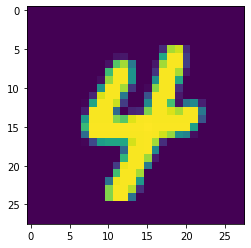

In [484]:
plt.imshow(img[0, 0, :, :])